In [10]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from inverse_problem import get_project_root
import torch
import torch.nn as nn
from astropy.io import fits
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.model_mlp_common import MlpCommonNet
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params
from torchsummary import summary
from tqdm import tqdm

## Датасет

Данные и немножко визаулизации

In [86]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

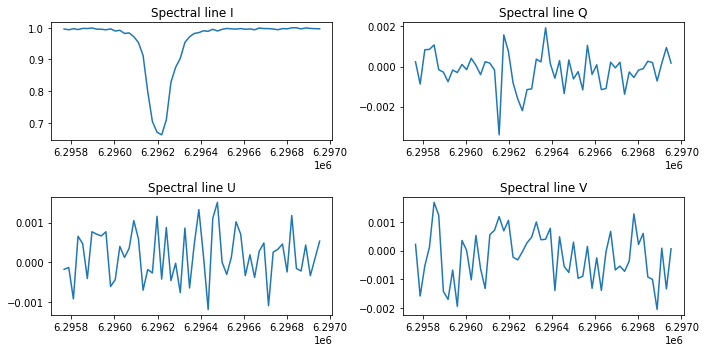

In [87]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

### Загрузка лоадера
Показаны два варианта: под вход полносвязной сети и под сверточный блок

In [96]:
MLP  = True

if MLP:
    transform_name = "mlp_transform_rescale"
    batch_size = 20
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name, batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
else:
    transform_name = "conv1d_transform_rescale"
    batch_size = 128
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name, batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
    

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])


можно загружать лоадер из массива, сейчас сделаю так чтобы на небольшом кусочке учить

In [100]:
param_array = fits.open(filename)[0].data[:100000]
transform_name = "mlp_transform_rescale"
train_loader, val_loader = make_loader(data_arr=param_array, transform_name=transform_name, batch_size=128)
sample_batch = next(iter(train_loader))
print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
print(f"Number of batches for train: {len(train_loader)}, for validation: {len(val_loader)}")

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])
Number of batches for train: 704, for validation: 79


## Загрузка (определение) модели

In [108]:
model = MlpCommonNet(input_dim=224, output_dim=11, hidden_dims=[200, 200, 100],
                           activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2);

In [109]:
print(model)

MlpCommonNet(
  (mlp): MLPBlock(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=224, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (1): MLPlayer(
        (linear): Linear(in_features=200, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (2): MLPlayer(
        (linear): Linear(in_features=200, out_features=100, bias=True)
        (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (readout): MLPReadout(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=101, out_features=50, bias=True)
        (batch_normx)

In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
model.to(device)

MlpCommonNet(
  (mlp): MLPBlock(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=224, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (1): MLPlayer(
        (linear): Linear(in_features=200, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (2): MLPlayer(
        (linear): Linear(in_features=200, out_features=100, bias=True)
        (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (readout): MLPReadout(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=101, out_features=50, bias=True)
        (batch_normx)

In [ ]:
def fit_step(dataloader):
    train_loss = 0.0
    train_it = 0
    max_steps = 500
    total = min(max_steps,len(dataloader))
    with tqdm(desc="batch", total=total) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if total == i:
                    break
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)
               
            outputs = model(x)
            
            optimizer.zero_grad()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_it += 1
            if train_it % 10 == 0:
                pbar_outer.update(100)
        return train_loss / train_it
def eval_step(dataloader):
    model.eval()
    val_loss = 0.0
    val_it = 0
    for i, inputs in enumerate(dataloader):
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)
        with torch.no_grad():
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it    

In [ ]:
best_valid_loss = float('inf')
history = []
log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
n_epochs = 2
with tqdm(desc="epoch", total = n_epochs) as pbar_outer:
    for epoch in range(n_epochs):
        train_loss = fit_step(train_loader)
        val_loss = eval_step(val_loader)
        history.append((train_loss, val_loss))
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
                                               v_loss=val_loss))
        